                                                        Programming Assignment -1 

 ### (a) CroppingandResizeImagesinYour4-classImagesDataset 
#### https://www.kaggle.com/code/espriella/stanford-dogs-transfer-crop-stack/notebook

In [3]:
import os
import xml.etree.ElementTree as ET
import cv2

directory = os.getcwd()
main_img_folder = 'Images/'
main_annot_folder = 'Annotation/'
output_folder = "cropped_images"
target_size = (128, 128)
given_folders = ["n02090379-redbone","n02097047-miniature_schnauzer","n02104365-schipperke","n02112018-Pomeranian"]
os.makedirs(output_folder, exist_ok=True)
def is_xml_file(file_path):
    try:
        with open(file_path, 'r') as file:
            content = file.read()
            return '<annotation>' in content
    except Exception as e:
        return False

# Loop through each specific folder
for folder in given_folders:
    images_folder = os.path.join(main_img_folder, folder)
    annotations_folder = os.path.join(main_annot_folder, folder)

    for filename in os.listdir(annotations_folder):
        file_path = os.path.join(annotations_folder, filename)

        if is_xml_file(file_path):
            tree = ET.parse(file_path)
            root = tree.getroot()

            # Find image file corresponding to the annotation
            image_filename = root.find('filename').text
            image_path = os.path.join(directory, images_folder, image_filename)

            # Ensure correct file extension for the image
            image = cv2.imread(image_path+".jpg")
                
            if image is not None:
                for obj in root.findall('object'):
                    bbox = obj.find('bndbox')
                    xmin = int(bbox.find('xmin').text)
                    ymin = int(bbox.find('ymin').text)
                    xmax = int(bbox.find('xmax').text)
                    ymax = int(bbox.find('ymax').text)

                    # Crop and resize the region of interest (ROI)
                    roi = image[ymin:ymax, xmin:xmax]
                    roi_resized = cv2.resize(roi, target_size)

                    # Save the cropped and resized image
                    output_folder_path = os.path.join(output_folder, folder)
                    os.makedirs(output_folder_path, exist_ok=True)
                    output_path = os.path.join(output_folder_path, f'{image_filename}.jpg')
                    cv2.imwrite(output_path, roi_resized)


####  (b) Feature Extraction: Edge histogram AND Similarity Measurements
##### https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_rgb_to_gray.html
##### https://scikit-image.org/docs/stable/api/skimage.exposure.html#skimage.exposure.histogram
##### https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics
##### https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html#sphx-glr-auto-examples-features-detection-plot-hog-py
##### https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, exposure
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
def get_images(n):
    img= []
    for folder in os. listdir('cropped_images'):
        path = os.path. join('cropped_images', folder)
        if os. path. isdir (path):
            images = os. listdir (path)
            crop_images = [image for image in images if image. lower().endswith(('.jpg'))][:n] 
            for image in crop_images:
                src_path = os. path. join (path, image)
                img.append(src_path)
    return img

In [6]:
img=get_images(1)

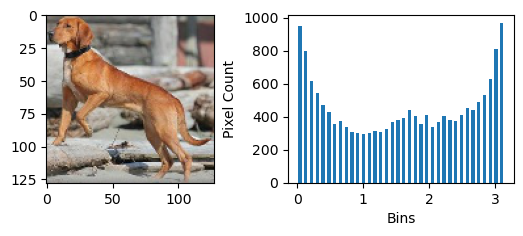

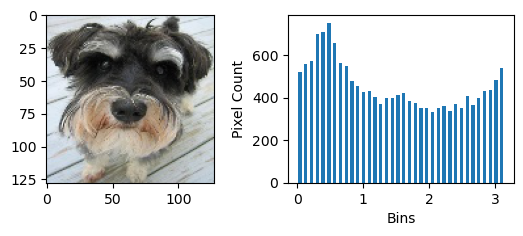

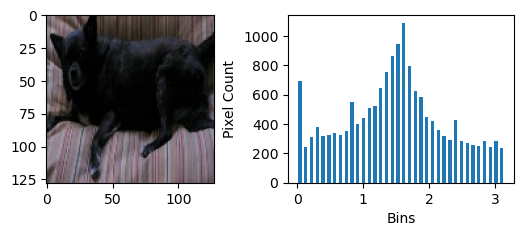

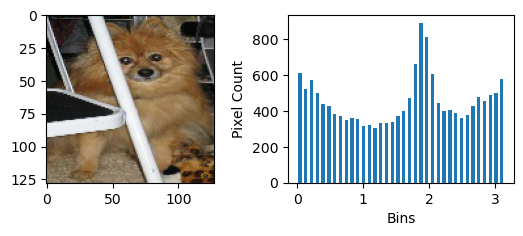

Euclidean Distance: 1602.912973308283
Manhattan Distance: 7818.0
Cosine Distance: 0.1486179553006004


In [7]:
def angle(dx, dy):
    """Calculate the angles between horizontal and vertical Sobel operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)
hist_vectors=[]
for imge in img:
    image = io.imread(imge)
    gray_img = color.rgb2gray(image)
    angle_sobel = angle(filters.sobel_h(gray_img), filters.sobel_v(gray_img))
    hist,hist_centers =exposure.histogram(angle_sobel,nbins=36)
    hist_vectors.append(hist)
    plt.subplot(221),plt.imshow(image)
    plt.subplot(222),plt.bar(hist_centers, hist, width=0.05, align='center'),plt.xlabel("Bins"),plt.ylabel("Pixel Count")
    plt.show()

hist1 = hist_vectors[1].reshape(1, -1)
hist2 = hist_vectors[2].reshape(1, -1)
    
# Calculate distances
euclidean = euclidean_distances(hist1, hist2)[0][0]
print(f"Euclidean Distance: {euclidean}")
manhattan = manhattan_distances(hist1, hist2)[0][0]
print(f"Manhattan Distance: {manhattan}")
cosine = cosine_distances(hist1, hist2)[0][0]
print(f"Cosine Distance: {cosine}")


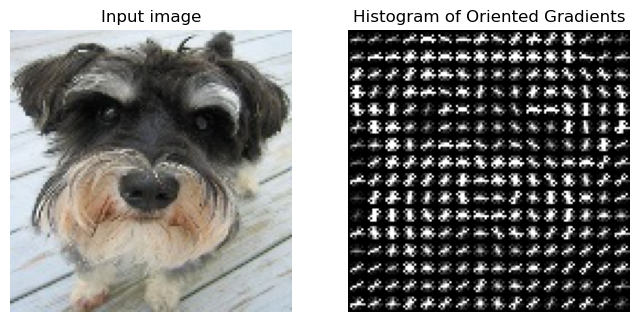

In [8]:
from skimage.feature import hog

image_path = img[1]
image = io.imread(image_path)
fd, hog_image = hog(
    image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap='gray')
ax2.set_title('Histogram of Oriented Gradients')
plt.show()





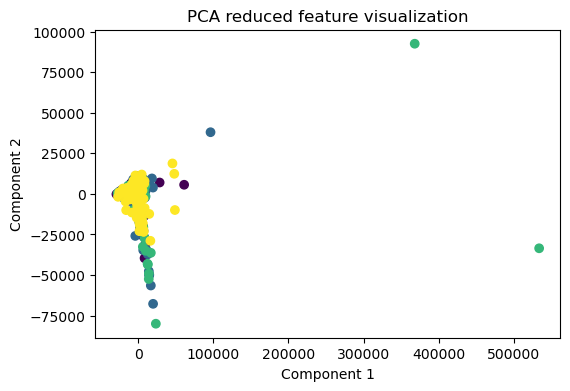

In [9]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

edge_histograms = []
labels = []

for class_idx, class_name in enumerate(given_folders):
    class_folder = os.path.join(main_img_folder, class_name)
    for image_file in os.listdir(class_folder):
        if image_file.endswith('.jpg') or image_file.endswith('.png'):  
            image_path = os.path.join(class_folder, image_file)
            image = io.imread(image_path)
            gray_img = color.rgb2gray(image)
            angle_sobel = angle(filters.sobel_h(gray_img), filters.sobel_v(gray_img))
            hist,hist_centers =exposure.histogram(angle_sobel,nbins=36)
            edge_histograms.append(hist)
            labels.append(class_idx)

edge_histograms = np.array(edge_histograms)
labels = np.array(labels)
pca = PCA(n_components=2)
histograms_pca = pca.fit_transform(edge_histograms)

plt.figure(figsize=(6, 4))
plt.scatter(histograms_pca[:, 0], histograms_pca[:, 1], c=labels)

plt.title('PCA reduced feature visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


# As i can see in my figure all classes are overlapping so no classes are visually separable 

####  text processing steps on a tweet (i.e., text) dataset
##### https://scikit-learn.org/stable/api/sklearn.feature_extraction.html#module-sklearn.feature_extraction.text

In [12]:
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
file_path = 'train.json'
data = []
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))
df = pd.DataFrame(data)

print(df.head(2))
texts = df['Tweet'].astype(str)

count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

count_matrix = count_vectorizer.fit_transform(texts)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Print the dimensionality
print("CountVectorizer dimensions:", count_matrix.shape)
print("TfidfVectorizer dimensions:", tfidf_matrix.shape)

count_df = pd.DataFrame(count_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

              ID                                              Tweet  anger  \
0  2017-En-40457  Niggas murking in each other. In murky water, ...   True   
1  2017-En-41422  @funkxwidme only #true #depression #fans will ...  False   

   anticipation  disgust   fear    joy   love  optimism  pessimism  sadness  \
0         False     True  False  False  False      True      False    False   
1         False    False  False  False  False     False       True     True   

   surprise  trust  
0     False  False  
1     False  False  
CountVectorizer dimensions: (3000, 9562)
TfidfVectorizer dimensions: (3000, 9562)


In [13]:
for class_name in ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']:
    print(f"Top tokens for class: {class_name}")
    
    # Get tweets where the class is True
    class_tweets = df[df[class_name] == True]
    
    # Sum the token counts for the selected class
    class_counts = count_df.loc[class_tweets.index].sum().sort_values(ascending=False).head(10)
    tf_counts = tfidf_df.loc[class_tweets.index].sum().sort_values(ascending=False).head(10)
    print(class_counts,tf_counts)
    print()

Top tokens for class: anger
the     538
to      430
and     319
is      253
it      221
you     215
of      211
in      193
that    185
my      166
dtype: int64 the     44.125561
to      37.947209
and     31.901413
is      27.448886
you     25.472938
it      24.831852
me      23.469322
that    23.010648
my      22.853498
of      21.892766
dtype: float64

Top tokens for class: anticipation
the     192
to      190
and      90
is       88
in       87
of       86
it       77
you      71
for      66
that     65
dtype: int64 to      17.307969
the     16.193444
in      10.189251
is       9.538813
it       9.534103
and      9.258451
of       9.127534
for      8.973453
you      8.652191
that     8.373725
dtype: float64

Top tokens for class: disgust
the     543
to      433
and     319
is      262
of      235
you     216
in      201
it      195
that    186
my      155
dtype: int64 the     44.621758
to      37.957937
and     32.137983
is      28.514551
you     26.097386
of      24.280455
that    

### based on the count vectorizer and tfidf vectorizer i find Anger, love, surprise , fear to be the separable features as they have unique tokens which separate from other classes.

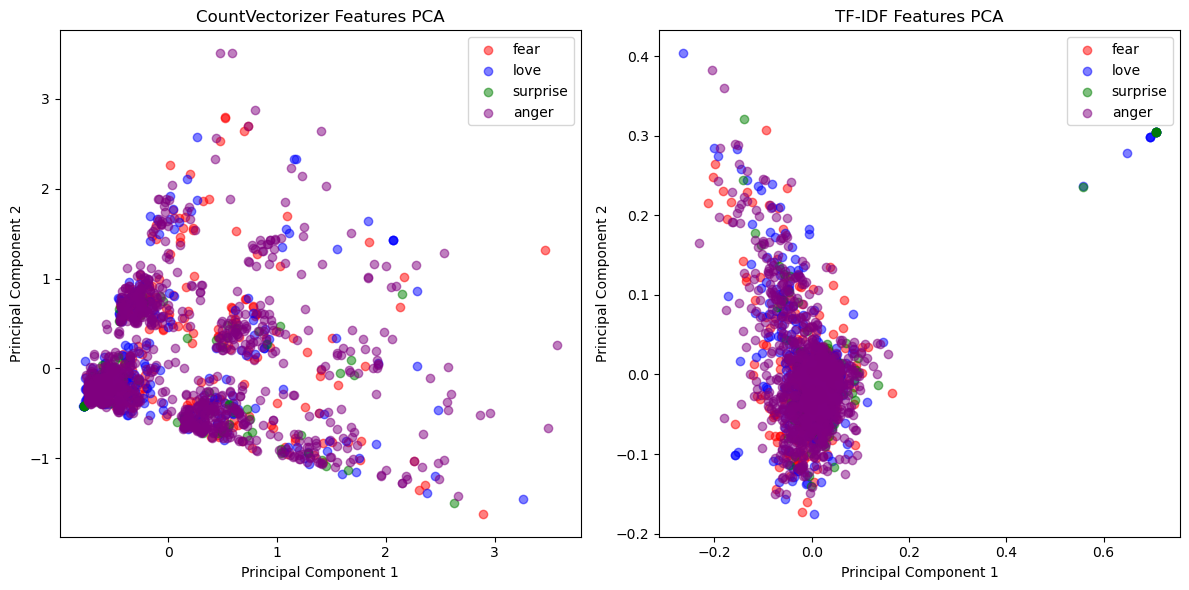

In [15]:
import warnings
warnings.filterwarnings("ignore")
# Filter for selected classes
selected_classes = ['anger', 'love', 'surprise', 'fear']
df_filtered = df[df[selected_classes].any(axis=1)]

X_count = CountVectorizer().fit_transform(df_filtered['Tweet'])
X_tfidf = TfidfVectorizer().fit_transform(df_filtered['Tweet'])

# Dimensionality Reduction
pca_count = PCA(n_components=2).fit_transform(X_count.toarray())
pca_tfidf = PCA(n_components=2).fit_transform(X_tfidf.toarray())

# Create a color map for the classes
class_colors = {'fear': 'red', 'love': 'blue', 'surprise': 'green', 'anger': 'purple'}
df_filtered['class'] = df_filtered[selected_classes].idxmax(axis=1) 
df_filtered['color'] = df_filtered['class'].map(class_colors)

# Plot CountVectorizer
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for class_name, color in class_colors.items():
    plt.scatter(pca_count[df_filtered['class'] == class_name, 0], 
                pca_count[df_filtered['class'] == class_name, 1], 
                label=class_name, color=color, alpha=0.5)
plt.title('CountVectorizer Features PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Plot TfidfVectorizer
plt.subplot(1, 2, 2)
for class_name, color in class_colors.items():
    plt.scatter(pca_tfidf[df_filtered['class'] == class_name, 0], 
                pca_tfidf[df_filtered['class'] == class_name, 1], 
                label=class_name, color=color, alpha=0.5)
plt.title('TF-IDF Features PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

plt.tight_layout()
plt.show()

## visually classes are not separable on either plots.